<a href="https://colab.research.google.com/github/greyxray/mbd_research_notebooks/blob/main/Knowledge_Sharing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
from graphviz import Digraph
import matplotlib.pyplot as plt

# Aim:
We'll talk about deep learning, but not JUST deep learning. My hope is to also bring up some interesting engineering challenges.

We will begin by starting with shallow neural networks, backpropagation and optimization techniques.

Next we will go into convolutional neural networks, the history of CNN architectures, some interesting and useful libraries.

Then we talk about image classification, object detection and segmentation.

From there we will go into generative models, hopefully talking about GANs, normalizing flows and score based models (diffusion models).

The goal is to keep up to date with topics in deep learning, think of ways where we might see these techniques being useful at the org and the engineering challenges will also translate to real world problem solving.

This may also provide inspiration and motivation, which is never a bad thing.


### So let's begin by asking a simple question: what is a neural networks?
Simply put: Just a bunch of numbers, which are found using data. These numbers and some input are together passed through a computational graph made of simple operations to produce an output.

Another way of looking at is: It's a function, can be a very complicated and long function, but always a function.


## Today's Topic:
Let's look at it more in depth as a function, talk about gradients, how backpropagation works and how pytorch implements computational graphs and backprop:

I know this is a team of data scientists and this topic might be already familiar, or trivial to you. But it's good practice to start from the bottom, so that we are all on the same page regarding notation and intricacies.

In [6]:
# Let's define a simple function - A parabola in this case
def f(x):
    return 4*x**2 + 4

# Yay we can evaluate this function at a given input value
f(3)

40

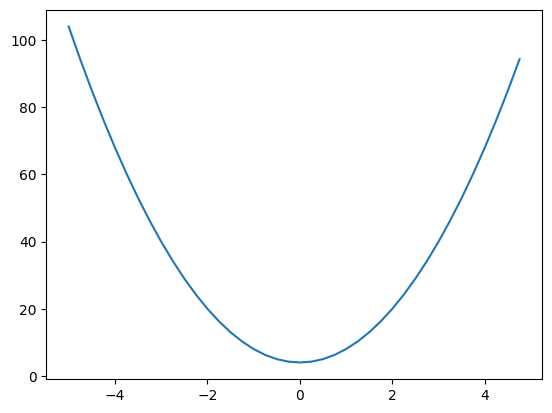

In [7]:
# Let's plot the function over a range of -5 to 5
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

Functions can be differentiated (assuming there are no discontinuities in the function). Symbolic differentiation is what we've been taught in calculus, but in computers it is much more easier to simply just use the analytic gradient.
The analytic gradient is: (f(x + h) - f(x)) / h where h approaches 0. So basically, how much does the function change, if the input changes very slightly. Here is a demonstration of the analytic gradient for the function defined above.

In [8]:
# Analytic gradient
h = 0.0001
x = -1
grad = (f(x + h) - f(x)) / h
grad

# Symbolic graident = d/dx(4x**2 + 4) -> 8x + 0 -> 8x -> 8(-1) -> -8

# Yaayyy symbolic == analytic (approximately)

-7.99960000000155

In [3]:
# Slightly more complex:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c

d1 = a * b + c
a += h
d2 = a * b + c
print("gradient of d w.r.t a:", (d2-d1)/h)

gradient of d w.r.t a: -3.000000000010772


Let's build up from here and create a datastructure which will allow us to define computational graphs, and calculate gradients (leading us to backprop):

In [10]:
class Scalar:

    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Scalar(data={self.data})"

a = Scalar(2.0)
b = Scalar(-3.0)
c = Scalar(10.0)
print(a)

Scalar(data=2.0)


Nothing special so far, but we can add some python operations to our class so we can add and multiply different Scalar objects together:

In [11]:
class Scalar:

    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Scalar(data={self.data})"

    def __add__(self, other):
        out = self.data + other.data
        return Scalar(out)

    def __mul__(self, other):
        out = self.data * other.data
        return Scalar(out)

a = Scalar(2.0)
b = Scalar(-3.0)
c = Scalar(10.0)
d = a * b + c
print(d)

Scalar(data=4.0)


So now we have the "computational" part of the computational graph. Let's add the graph part:

We include a "_prev" attribute which basically stores which scalar objects created this Scalar.

In [12]:
class Scalar:

    def __init__(self, data, _children=()):
        self.data = data
        self._prev = set(_children)

    def __repr__(self):
        return f"Scalar(data={self.data})"

    def __add__(self, other):
        out = self.data + other.data
        return Scalar(out, (self, other))

    def __mul__(self, other):
        out = self.data * other.data
        return Scalar(out, (self, other))

a = Scalar(2.0)
b = Scalar(-3.0)
c = Scalar(10.0)
d = a * b + c
print(d)
print(d._prev)

Scalar(data=4.0)
{Scalar(data=-6.0), Scalar(data=10.0)}


For completeness, let's record what operation created the new Scalar as well:

In [13]:
class Scalar:

    def __init__(self, data, _children=(), _op=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f"Scalar(data={self.data})"

    def __add__(self, other):
        out = self.data + other.data
        return Scalar(out, (self, other), "+")

    def __mul__(self, other):
        out = self.data * other.data
        return Scalar(out, (self, other), "*")

a = Scalar(2.0)
b = Scalar(-3.0)
c = Scalar(10.0)
d = a * b + c
print(d)
print(d._prev)
print(d._op)

Scalar(data=4.0)
{Scalar(data=-6.0), Scalar(data=10.0)}
+


Some boilerplate code to draw the computational graph given a root node:

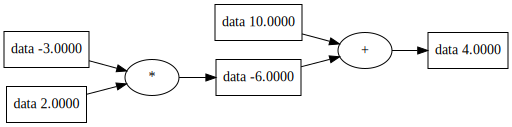

In [14]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw(root):
    g = Digraph(format="svg", graph_attr={"rankdir": "LR"})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        g.node(name=uid, label= "{ data %.4f}" % (n.data, ), shape="record")
        if n._op:
            g.node(name = uid + n._op, label = n._op)
            g.edge(uid + n._op, uid)

    for n1, n2 in edges:
        g.edge(str(id(n1)), str(id(n2)) + n2._op)
    return g

draw(d)

Yay, now I've proved to you that computational graphs can be built in just a couple of lines of code. Not much overhead required at all. Now let's turn this into a "deep learning" library by adding the capability to store gradients for each node, so we can run backpropagation:

Scalar(data=48.0)
{Scalar(data=4.0), Scalar(data=12)}


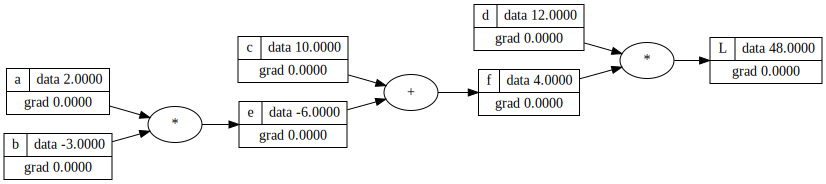

In [15]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw(root):
    g = Digraph(format="svg", graph_attr={"rankdir": "LR"})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        g.node(name=uid, label= "{ %s |data %.4f} | {grad %.4f} " % (n.label, n.data, n.grad), shape="record")
        if n._op:
            g.node(name = uid + n._op, label = n._op)
            g.edge(uid + n._op, uid)

    for n1, n2 in edges:
        g.edge(str(id(n1)), str(id(n2)) + n2._op)
    return g


class Scalar:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.grad = 0.0
        self.label = label

    def __repr__(self):
        return f"Scalar(data={self.data})"

    def __add__(self, other):
        out = self.data + other.data
        return Scalar(out, (self, other), "+")

    def __mul__(self, other):
        out = self.data * other.data
        return Scalar(out, (self, other), "*")

a = Scalar(2.0, label = "a")
b = Scalar(-3.0, label = "b")
c = Scalar(10.0, label = "c")
d = Scalar(12, label="d")
e = a * b; e.label = "e"
f = e + c; f.label = "f"
L = d * f; L.label = "L"
print(L)
print(L._prev)
draw(L)

So now we know which variables create new variables, what each of their gradients are, and which operation creates them. Now let's run backpropagation assuming L is our loss function on this very simple computational graph.

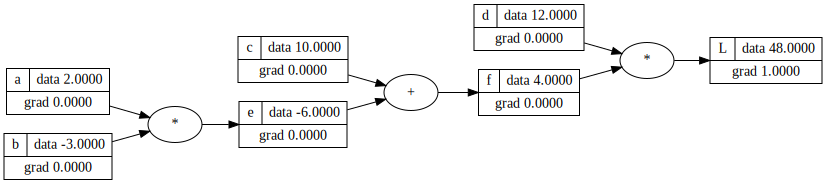

In [16]:
# dL/dL is trivially 1:
L.grad = 1
draw(L)

Let's do some calculus to figure out what each of these node's gradient is:

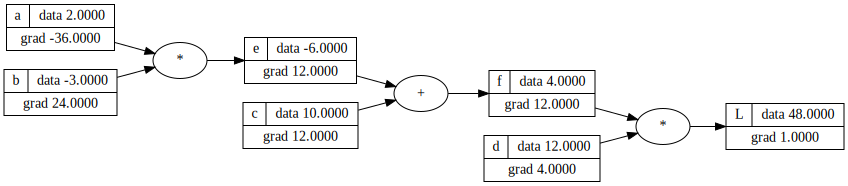

In [ ]:
# a = Scalar(2.0, label = "a")
# b = Scalar(-3.0, label = "b")
# c = Scalar(10.0, label = "c")
# d = Scalar(12, label="d")
# e = a * b; e.label = "e"
# f = e + c; f.label = "f"
# L = d * f; L.label = "L"

#dl/df = d = 12
#dl/dd = f = 4
#df/de = 1
#df/dc = 1
#dl/de = dl/df * df/de
#dl/dc = dl/df * df/dc
#de/db = a
#de/da = b
#dl/db = de/db * dl/de
#dl/da = de/da * dl/de


f.grad = 12
d.grad = 4
e.grad = 12
c.grad = 12
b.grad = 2 * 12
a.grad = -3 * 12
draw(L)

You might have noticed a pattern that for intermediary nodes, the gradient is always obtained using the chain rule. And this chain rule is always a multiplication of the gradient coming from upstream (coming from loss) and the gradient of the current node (how much this node affects it's output).

This is all backpropagation is. A recursive computation of the chain rule. Look at the plot above, the gradients are now filled in. Our manual backprop computational graph works.

Below, we can use pytorch (or even analytic gradients) to check if our computation is correct:

In [ ]:
import torch
a = torch.tensor([2.0], requires_grad=True)
b = torch.tensor([-3.0], requires_grad=True)
c = torch.tensor([10.0], requires_grad=True)
d = torch.tensor([12.0], requires_grad=True)
e = a * b
f = e + c
L = d * f
f.retain_grad()
e.retain_grad()
L.backward()
print(f.grad)
print(d.grad)
print(e.grad)
print(c.grad)
print(b.grad)
print(a.grad)

tensor([12.])
tensor([4.])
tensor([12.])
tensor([12.])
tensor([24.])
tensor([-36.])


Cool, pytorch agrees with us. You may at this point, notice how similar torch.Tensor and our Scalar class are. They both provide the same functionality. PyTorch is 'slightly' more powerful because instead of scalars, you can operate on tensors (but really a tensor is just a collection of scalars, isn't it?). Notice how also, calling .backward() on L populated gradients automatically. This is why pytorch is an "autograd" engine. We didn't have to do any calculus and manual backprop.

If you are interested, maybe think about how you will extend the Scalar class to also provide autograd functionality by including a .backward() function.

While we didn't look at "neural networks" here. We did look at functions and how pytorch and computers handle them. Neural networks are simply very gigantic functions, and prolly you ARE already familiar with what it is. So that part is left out for brevity.

### Now let's move onto: Why neural networks?
Simply put: They are universal function approximators (more on this later). And also because the layered architecture seems to work very well in practice. Why you may ask? that is a topic of research and there is no concrete answer yet.

### "Universal Function Approximator" you said?
This one gets thrown around a lot because it is self explanatory. But if someone were to ask us what it REALLY means, we might have a hard time explaining what this actually means.

So here goes: The universal approximation theorem simply states, that given any continuous function f(x), there is a SINGLE LAYER perceptron (ANN) g(x) for which, given any error bound 'e', |f(x) - g()| < e. That is the difference between the neural network output and the function value is less than e.

Now that the mathematics is out of the way, let's see a visual "proof" rather than a mathematical one.

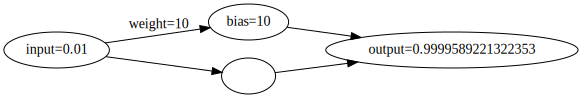

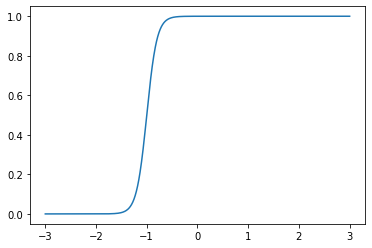

In [ ]:
plt.close("all")

def sigmoid(x, w, b):
    return 1 / (1 + np.exp(-1*(x * w + b)))

i = 0.01
w = 10
b = 10
o = sigmoid(i, w, b)
g = Digraph(graph_attr={"rankdir": "LR"})
g.node(name="Input", label=f"input={i}")
g.node(name="Output", label=f"output={o}")
g.node(name="Hidden", label=f"bias={b}")
g.node(name="Hidden_2", label="")
g.edge("Input", "Hidden", label=f"weight={w}")
g.edge("Hidden", "Output")
g.edge("Input", "Hidden_2")
g.edge("Hidden_2", "Output")

plt.figure()
x = np.linspace(-3, 3, 1000)
y = sigmoid(x, w, b)
plt.plot(x, y)

g

The above shows an input being multiplied by some weight, a bias being added, and the result being passed through a sigmoid function. This is what happens in a perceptron. What we are looking at in the graph above is just one "unit" of perceptron. The graph shows the output (sigmoid) as a function of the input when weight and bias are held constant.


If we increase the weight and the biases a bit, we can turn the output into a very good approximation of a unit step function:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


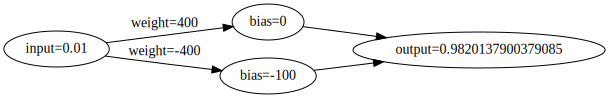

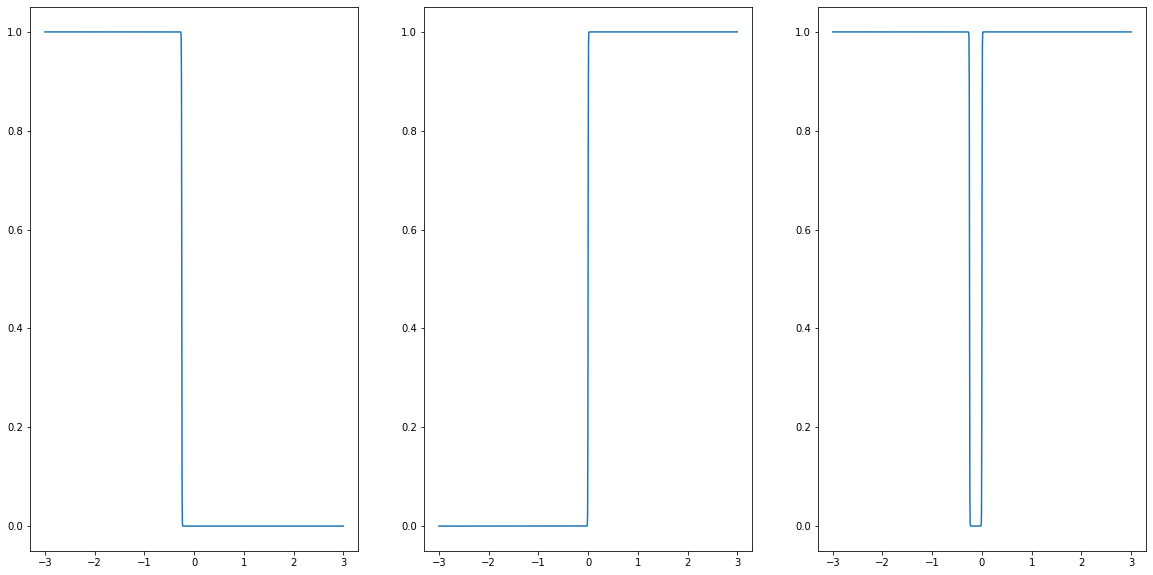

In [ ]:
plt.close("all")

i = 0.01
w1 = 400
w2 = -400
b1 = 0
b2 = -100
o = sigmoid(i, w1, b1) + sigmoid(i, w2, b2)
g = Digraph(graph_attr={"rankdir": "LR"})
g.node(name="Input", label=f"input={i}")
g.node(name="Output", label=f"output={o}")
g.node(name="Hidden", label=f"bias={b1}")
g.node(name="Hidden_2", label=f"bias={b2}")
g.edge("Input", "Hidden", label=f"weight={w1}")
g.edge("Hidden", "Output")
g.edge("Input", "Hidden_2", label=f"weight={w2}")
g.edge("Hidden_2", "Output")

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
x = np.linspace(-3, 3, 1000)
y1 = sigmoid(x, w1, b1)
y2 = sigmoid(x, w2, b2)
ax[1].plot(x, y1)
ax[0].plot(x, y2)
ax[2].plot(x, y1 + y2)

g

Now, our perceptron has 2 units, and both their sigmoid outputs are being added to produce the output. The output, shown as a function of the two inputs, when the weights and biases are held constant, are shown in the right most figure. See how simply by tweaking the values of W and b we can produce rectangles.

We can also produce as many rectangles as possible, simply by adding more and more units.

We can also modulate the magnitude of the step functions:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


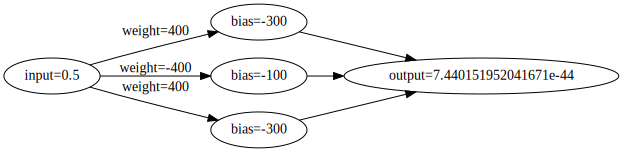

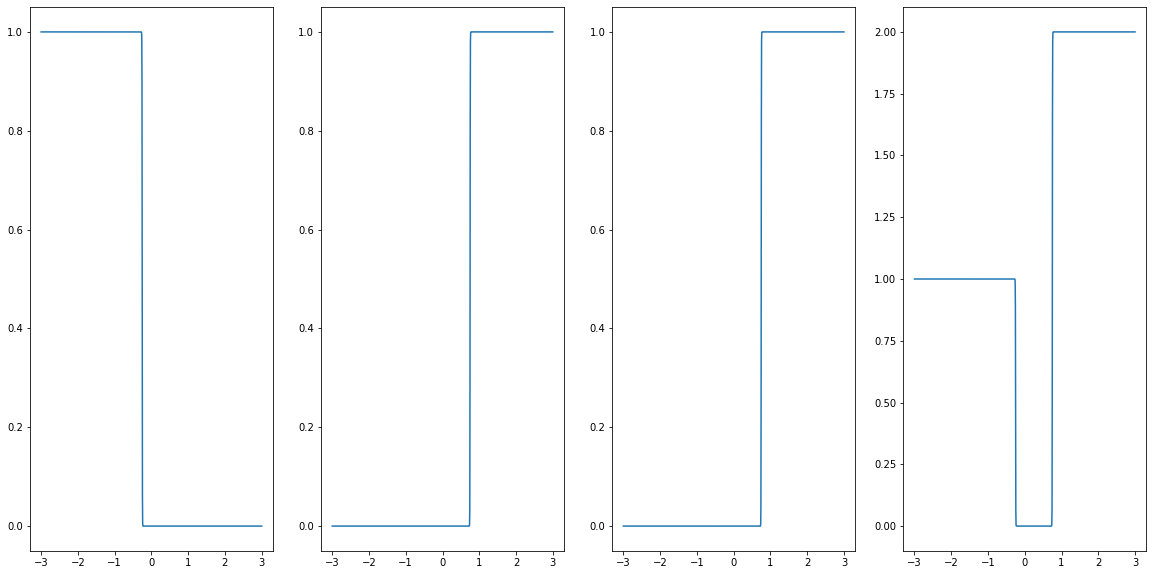

In [ ]:
plt.close("all")

i = 0.5
w1 = 400
w2 = -400
w3 = 400
b1 = -300
b2 = -100
b3 = -300
o = sigmoid(i, w1, b1) + sigmoid(i, w2, b2) + sigmoid(i, w3, b3)
g = Digraph(graph_attr={"rankdir": "LR"})
g.node(name="Input", label=f"input={i}")
g.node(name="Output", label=f"output={o}")
g.node(name="Hidden_1", label=f"bias={b1}")
g.node(name="Hidden_2", label=f"bias={b2}")
g.node(name="Hidden_3", label=f"bias={b3}")
g.edge("Input", "Hidden_1", label=f"weight={w1}")
g.edge("Hidden_1", "Output")
g.edge("Input", "Hidden_2", label=f"weight={w2}")
g.edge("Hidden_2", "Output")
g.edge("Input", "Hidden_3", label=f"weight={w3}")
g.edge("Hidden_3", "Output")

fig, ax = plt.subplots(1, 4, figsize=(20, 10))
x = np.linspace(-3, 3, 1000)
y1 = sigmoid(x, w1, b1)
y2 = sigmoid(x, w2, b2)
y3 = sigmoid(x, w3, b3)
ax[1].plot(x, y1)
ax[0].plot(x, y2)
ax[2].plot(x, y3)
ax[3].plot(x, y1 + y2 + y3)

g

I added one more neuron, which as simply the same as one of the previous neurons, so the rightmost figure shows how the unit step function at that point goes up to a value of 2.

We have seen that:
1 - We can create as many rectangles as possible (simply create more neurons)
2 - We can change their magnitude (simply create more neurons that constructively or desctructively add)
3 - We can change the rectangle's width (by adding more neurons).

Summary: The above shows how simply controlling the WIDTH (the number of neurons) of the perceptron, and the magnitude of the weight and bias, we can produce any arbitrary combinations of step functions.

Now imagine this as an approximation for integrals of functions which automatically makes it a good approximation of the function value. The rectangles can be made smaller and smaller by adding more and more units to better approximate the function. So you could non trivially create tinier and tinier rectangles that have magnitudes that are the same as some function value (the function you are trying to approximate). This satisfies the universal function approximation theorem.

In [ ]:
# Hint for adding a backward function

class Scalar:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self._prev = set(_children)
        # Backward is a class function, initially does nothing
        self._backward = lambda: None
        self._op = _op
        self.grad = 0.0
        self.label = label

    def __repr__(self):
        return f"Scalar(data={self.data})"

    def __add__(self, other):
        out = Scalar(self.data + other.data, (self, other), "+")

        # When this creates 'out', we need to populate out's gradient
        def _backward():
            # Chain rule: local gradient * global gradient
            # Local gradient: d(self)/d(self) + d(other)/d(self) = 1 + 0 = 1
            # Global gradient: out.grad
            # Chain rule: 1 * out.grad
            # self.grad = out.grad
            # other.grad = out.grad
            # But if these variables are used more than once,
            # we need to accumulate gradients, instead of assigning them
            self.grad += out.grad
            # similar process as above for other:
            other.grad += out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Scalar(self.data * other.data, (self, other), "*")

        # What would be the backward function for multiplication?
        def _backward():
          # TODO: Implement me
          pass
        self._backward = backward
        return out

    def backward():

      # TODO: Topological sort from 'self' down every _prev member
      # all the way to the start (make a list of all scalars sorted
      # topologically, starting from self)
      # self.grad = 1 # gradient on self is always one (dx/dx = 1)
      # For Scalar in topological sorted order: call scalar._backward()
      # now all gradients are populated. Cross check with pytorch to
      # confirm your implementation is correct
      pass